In [2]:
import sys
import os

# Add the project's root directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
from dotenv import load_dotenv
import os

# Load environment variables from .env file
dotenv_path = '../.env'
load_dotenv(dotenv_path)

# Get database credentials from environment variables
user = os.getenv('DB_USER')
password = os.getenv('DB_PASSWORD')
host = os.getenv('DB_HOST')
port = os.getenv('DB_PORT')
db_name = os.getenv('DB_NAME')

# Create the database connection string
connection_string = f"postgresql://{user}:{password}@{host}:{port}/{db_name}"

# Create the SQLAlchemy engine
engine = create_engine(connection_string)

print("Connection to database established successfully.")

# --- Test Query ---
# Let's run a simple query to fetch the first 5 customers to verify the connection
query = "SELECT * FROM olist_customers LIMIT 5;"
df_test = pd.read_sql(query, engine)

df_test.head()

Connection to database established successfully.


,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


RFM Analysis Explained: 
RFM is a powerful marketing analysis technique used to segment customers based on their behavior. It stands for:

Recency (R): How recently did the customer make a purchase?

Frequency (F): How often do they make purchases?

Monetary (M): How much money do they spend?


This query uses Common Table Expressions (CTEs) to build the logic step-by-step, which is a clean and efficient way to write complex SQL.

In [3]:
# This query joins customers, orders, and payments to calculate RFM metrics.
# We use Common Table Expressions (CTEs) to build the logic step-by-step.

rfm_query = """
WITH
  -- First, get the most recent purchase date in the entire dataset to calculate recency against a fixed point in time.
  snapshot_date AS (
    SELECT
      MAX(order_purchase_timestamp) AS max_purchase_date
    FROM
      olist_orders
  ),
  
  -- Next, join the necessary tables and filter for completed orders.
  customer_orders AS (
    SELECT
      c.customer_unique_id,
      o.order_id,
      o.order_purchase_timestamp,
      p.payment_value
    FROM
      olist_customers AS c
      JOIN olist_orders AS o ON c.customer_id = o.customer_id
      JOIN olist_order_payments AS p ON o.order_id = p.order_id
    WHERE
      o.order_status = 'delivered' AND o.order_purchase_timestamp IS NOT NULL
  )
  
-- Now, calculate the R, F, and M values for each unique customer.
SELECT
  co.customer_unique_id,
  -- Recency: Days since the customer's last purchase from the snapshot date.
  DATE_PART('day', (SELECT max_purchase_date FROM snapshot_date) - MAX(co.order_purchase_timestamp)) AS recency,
  -- Frequency: Total number of distinct orders.
  COUNT(DISTINCT co.order_id) AS frequency,
  -- Monetary: Total sum of payments.
  SUM(co.payment_value) AS monetary
FROM
  customer_orders AS co
GROUP BY
  co.customer_unique_id
ORDER BY
    monetary DESC;
"""

# Execute the query and load the results into a new DataFrame
df_rfm = pd.read_sql(rfm_query, engine)

print("RFM calculation complete.")
df_rfm.head()

RFM calculation complete.


,customer_unique_id,recency,frequency,monetary
0,0a0a92112bd4c708ca5fde585afaa872,383.0,1,13664.08
1,da122df9eeddfedc1dc1f5349a1a690c,564.0,2,7571.63
2,763c8b1c9c68a0229c42c9fc6f662b93,94.0,1,7274.88
3,dc4802a71eae9be1dd28f5d788ceb526,611.0,1,6929.31
4,459bef486812aa25204be022145caa62,83.0,1,6922.21


What this query does:

snapshot_date: It first finds the absolute latest purchase date in the entire dataset. We use this as our "today" to calculate recency. This ensures that if we run the analysis again tomorrow, the numbers don't change, making it reproducible.

customer_orders: It joins the customers, orders, and payments tables and filters for only successfully delivered orders.

Final SELECT: It then calculates the Recency, Frequency, and Monetary values for each unique customer and orders them by who spent the most.

Exploring RFM Distributions

Before we create segments, it's crucial to understand the distribution of our Recency, Frequency, and Monetary values. Are they evenly spread out, or are they skewed? This will help us create fair and balanced segments. We'll use histograms to visualize this.

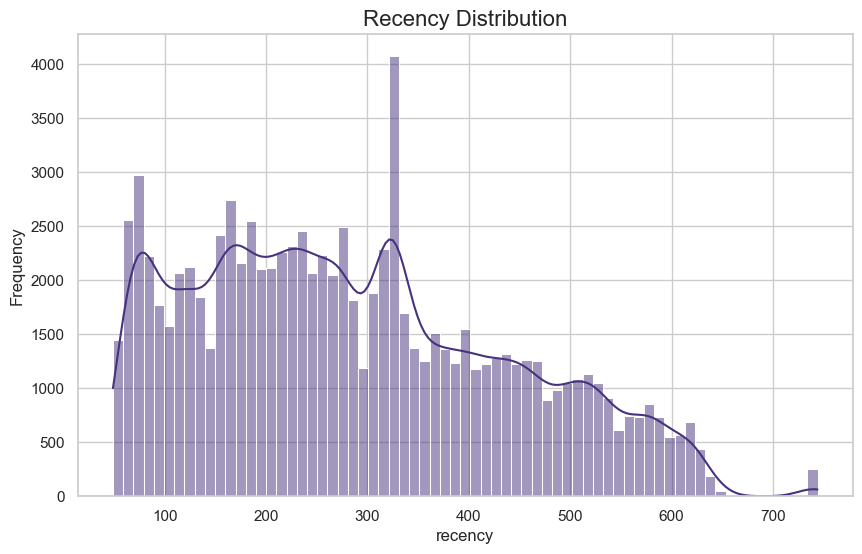

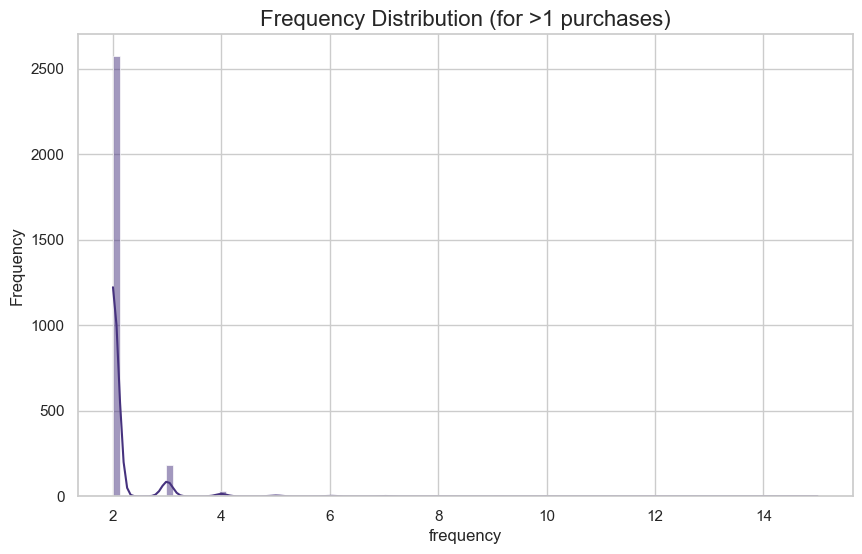

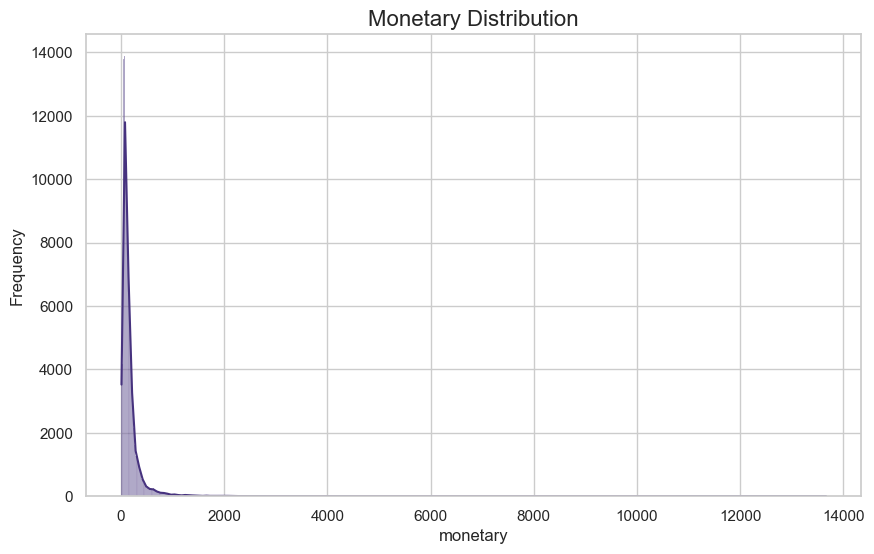

Summary statistics for RFM values:


,recency,frequency,monetary
count,93357.000000,93357.000000,93357.000000
mean,286.100367,1.033420,165.198772
std,152.584573,0.209099,226.314579
min,49.000000,1.000000,9.590000
25%,163.000000,1.000000,63.060000
50%,267.000000,1.000000,107.780000
75%,394.000000,1.000000,182.560000
max,744.000000,15.000000,13664.080000


In [4]:
# Import the specific function we need from our new utility file
from plotting_utils import plot_histogram

# --- Visualize Distributions using our new function ---

# Plot Recency
plot_histogram(
    data=df_rfm,
    column='recency',
    title='Recency Distribution'
)

# Plot Frequency (for customers with more than one purchase)
plot_histogram(
    data=df_rfm[df_rfm['frequency'] > 1],
    column='frequency',
    title='Frequency Distribution (for >1 purchases)'
)

# Plot Monetary
plot_histogram(
    data=df_rfm,
    column='monetary',
    title='Monetary Distribution'
)

# Display summary statistics, which is still very useful
print("Summary statistics for RFM values:")
df_rfm[['recency', 'frequency', 'monetary']].describe()

Creating RFM Scores and Segments

The distributions are heavily skewed, which is very common in this type of data. A simple and effective way to handle this is to segment customers based on quantiles. We'll divide each metric into 4 equal groups (quartiles) and assign a score from 1 to 4.

-   For **Recency**, a lower value is better (more recent), so we'll assign the highest score (4) to the most recent customers.
-   For **Frequency** and **Monetary**, a higher value is better, so we'll assign the highest score (4) to the customers with the highest frequency and spending.

In [5]:
# Create RFM scores based on quantiles (quartiles)
df_rfm['r_score'] = pd.qcut(df_rfm['recency'], 4, labels=[4, 3, 2, 1]) # Lower recency is better
df_rfm['f_score'] = pd.qcut(df_rfm['frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4]) # Higher frequency is better
df_rfm['m_score'] = pd.qcut(df_rfm['monetary'], 4, labels=[1, 2, 3, 4]) # Higher monetary is better

# Combine the scores to get a final RFM score
df_rfm['rfm_score'] = df_rfm['r_score'].astype(str) + df_rfm['f_score'].astype(str) + df_rfm['m_score'].astype(str)

df_rfm.head()

,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score
0,0a0a92112bd4c708ca5fde585afaa872,383.0,1,13664.08,2,1,4,214
1,da122df9eeddfedc1dc1f5349a1a690c,564.0,2,7571.63,1,4,4,144
2,763c8b1c9c68a0229c42c9fc6f662b93,94.0,1,7274.88,4,1,4,414
3,dc4802a71eae9be1dd28f5d788ceb526,611.0,1,6929.31,1,1,4,114
4,459bef486812aa25204be022145caa62,83.0,1,6922.21,4,1,4,414


Defining Customer Segments

Now that we have a combined score (e.g., '444' for the best customers), we can map these scores to descriptive segment names. This makes the analysis much more intuitive for business stakeholders. We'll define a few key segments.

In [6]:
def segment_customer(rfm_score):
    """
    Categorizes an RFM score string into a descriptive segment name.
    """
    if rfm_score in ['444', '443', '434', '433', '344', '343', '334', '333']:
        return 'Champions'
    elif rfm_score in ['441', '442', '431', '432', '421', '422', '341', '342', '331', '332', '321', '322']:
        return 'Potential Loyalists'
    elif rfm_score in ['411', '412', '311', '312']:
        return 'New Customers'
    elif rfm_score in ['244', '243', '234', '233', '224', '223']:
        return 'Loyal Customers'
    elif rfm_score in ['144', '143', '134', '133']:
        return 'At Risk'
    elif rfm_score in ['111', '112', '121', '122']:
        return 'Lost'
    else:
        # This 'else' catches every other combination
        return 'Others'

# Apply the function to the 'rfm_score' column to create the 'segment' column
df_rfm['segment'] = df_rfm['rfm_score'].apply(segment_customer)

print("Customer segmentation complete.")
df_rfm.head()

Customer segmentation complete.


,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment
0,0a0a92112bd4c708ca5fde585afaa872,383.0,1,13664.08,2,1,4,214,Others
1,da122df9eeddfedc1dc1f5349a1a690c,564.0,2,7571.63,1,4,4,144,At Risk
2,763c8b1c9c68a0229c42c9fc6f662b93,94.0,1,7274.88,4,1,4,414,Others
3,dc4802a71eae9be1dd28f5d788ceb526,611.0,1,6929.31,1,1,4,114,Others
4,459bef486812aa25204be022145caa62,83.0,1,6922.21,4,1,4,414,Others


Visualizing Customer Segments

Now that we have labeled our customers, let's visualize the size of each segment to understand the overall composition of our customer base. 

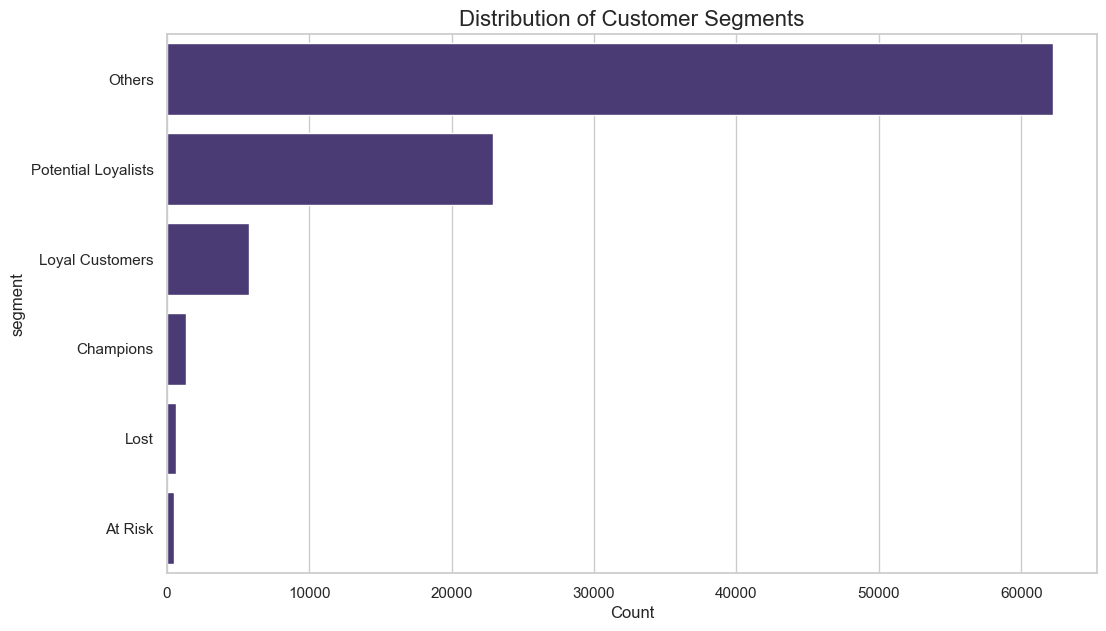

In [7]:
from plotting_utils import plot_countplot

# Visualize the distribution of customer segments
plot_countplot(
    data=df_rfm,
    column='segment',
    title='Distribution of Customer Segments',
    order_by_value=True # This will order the bars from most common to least common
)

Think of it like grading students in a class. We might have very clear rules for who gets an "A+" (the absolute top performers) and who gets an "F" (the lowest performers). Everyone else in the middle—the B, C, and D students—would fall into a general "Passing" category. Naturally, this middle group would be the largest.

"Average" (Others) customers are Common: Most customers are not extreme champions or completely lost causes. They are "average" customers who buy occasionally. Our rules don't have a specific name for a customer with a score of, for example, '222' or '313', so they are all grouped into "Others".

The Math: There are 64 possible RFM score combinations (from '111' to '444'). Our segment_customer function only defines rules for 38 of these specific combinations. The remaining 26 combinations, which represent over 40% of the possible outcomes, automatically fall into the "Others" category.

The Goal of Segmentation: This is actually a very common and useful outcome. The primary goal of this analysis was to identify actionable segments. We now have clear, well-defined groups like "Champions" (who we can reward) and "At Risk" customers (who we can try to win back). The large "Others" group represents the general customer population that might receive standard marketing.

Analyzing Segment Characteristics

The real value of segmentation comes from understanding the distinct behaviors of each group. We'll create a summary table that shows the average Recency, Frequency, and Monetary value for each segment, along with the number of customers in each group. This will give us a clear quantitative profile of our segments.

In [8]:
# Calculate the mean RFM values and the count for each segment
segment_analysis = df_rfm.groupby('segment').agg(
    recency_mean=('recency', 'mean'),
    frequency_mean=('frequency', 'mean'),
    monetary_mean=('monetary', 'mean'),
    customer_count=('customer_unique_id', 'count')
).round(1).sort_values(by='monetary_mean', ascending=False)

print("Segment Analysis Summary:")
segment_analysis

Segment Analysis Summary:


,recency_mean,frequency_mean,monetary_mean,customer_count
segment,,,,
Champions,161.3,2.2,343.2,1378
At Risk,483.5,2.1,327.4,496
Others,327.9,1.0,198.8,62196
Loyal Customers,325.1,1.1,158.8,5740
Lost,492.7,1.0,105.2,645
Potential Loyalists,160.3,1.0,63.1,22902


Visualizing Segment Profiles

The summary table is great for details, but plots make comparisons much more intuitive. Let's create bar charts to visually compare the average RFM values across our key segments. This will clearly highlight the differences in their behavior.

C:\Users\shaik\AppData\Local\Temp\ipykernel_29204\771694700.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_analysis.index, y=segment_analysis['recency_mean'], ax=axes[0], palette='viridis')
C:\Users\shaik\AppData\Local\Temp\ipykernel_29204\771694700.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_analysis.index, y=segment_analysis['frequency_mean'], ax=axes[1], palette='viridis')
C:\Users\shaik\AppData\Local\Temp\ipykernel_29204\771694700.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=segment_analysis.in

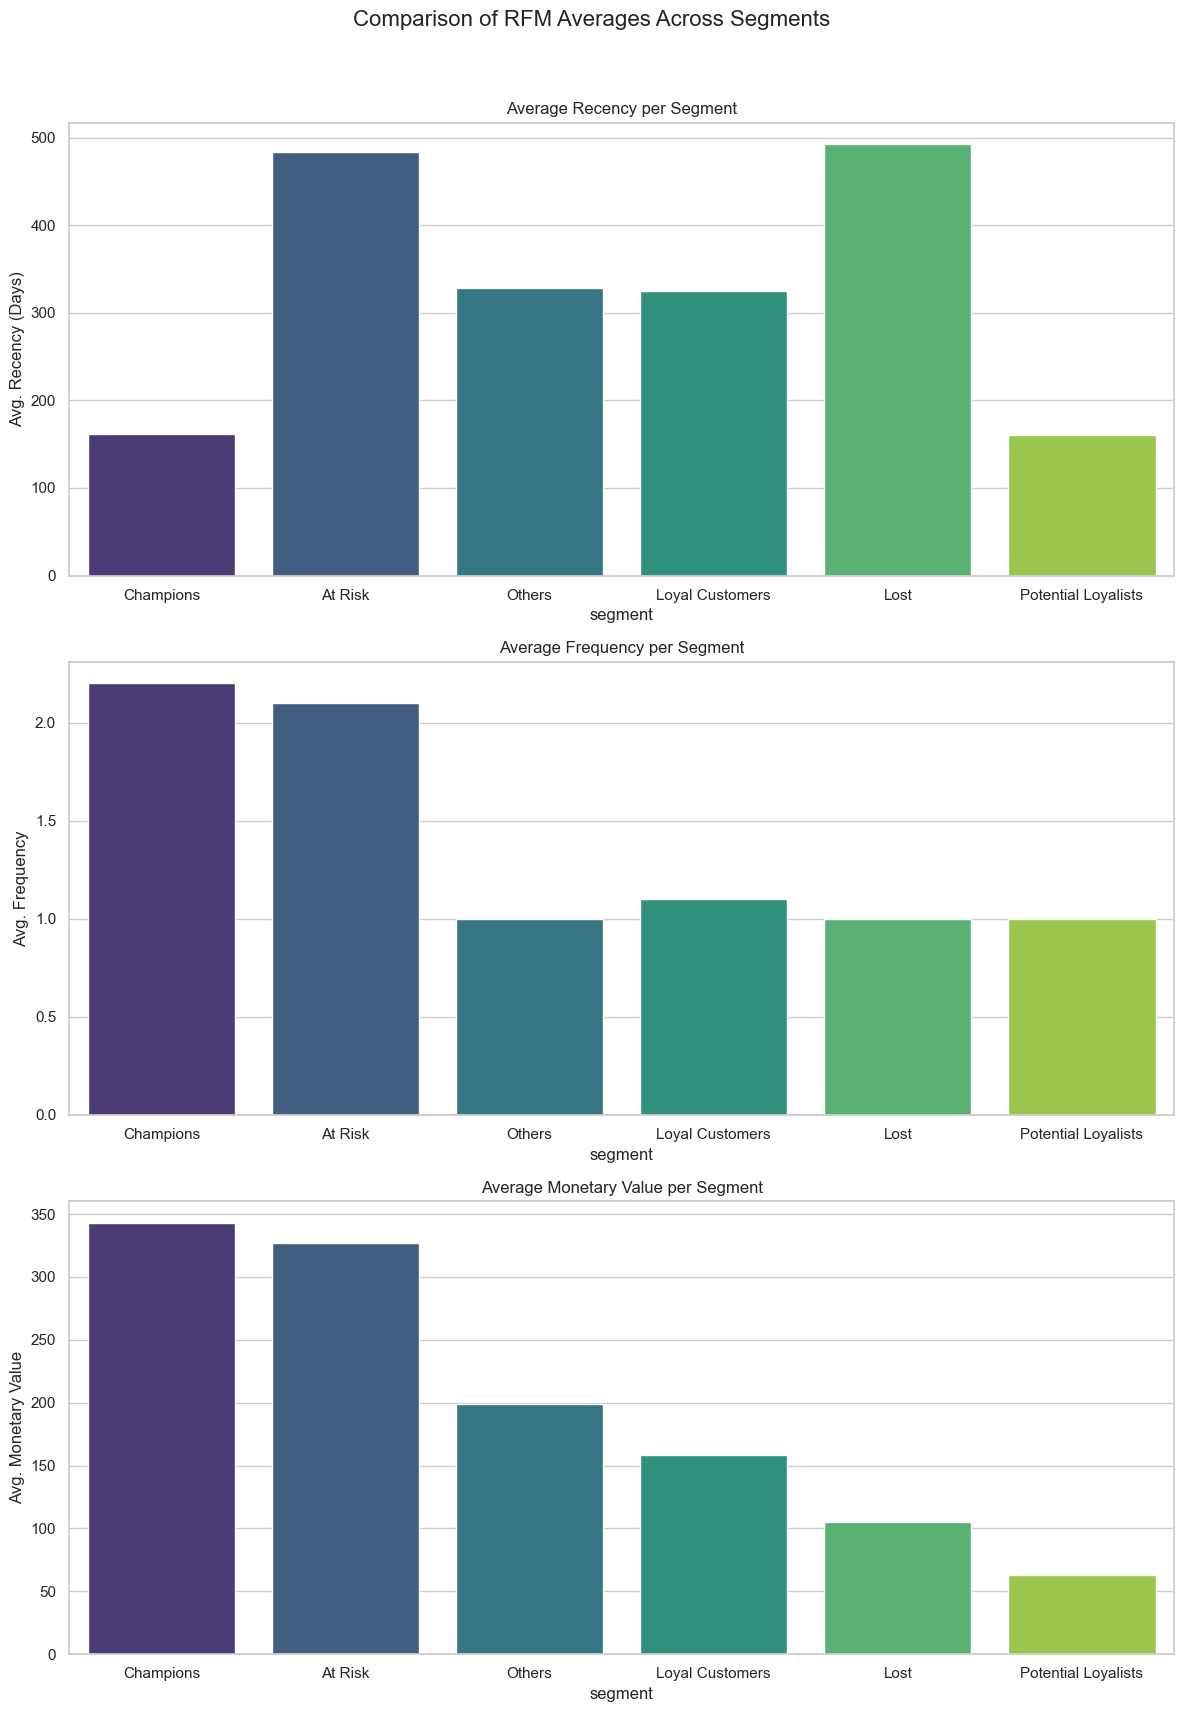

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create a figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(12, 18))
fig.suptitle('Comparison of RFM Averages Across Segments', fontsize=16)

# Plot Mean Recency
sns.barplot(x=segment_analysis.index, y=segment_analysis['recency_mean'], ax=axes[0], palette='viridis')
axes[0].set_title('Average Recency per Segment')
axes[0].set_ylabel('Avg. Recency (Days)')

# Plot Mean Frequency
sns.barplot(x=segment_analysis.index, y=segment_analysis['frequency_mean'], ax=axes[1], palette='viridis')
axes[1].set_title('Average Frequency per Segment')
axes[1].set_ylabel('Avg. Frequency')

# Plot Mean Monetary
sns.barplot(x=segment_analysis.index, y=segment_analysis['monetary_mean'], ax=axes[2], palette='viridis')
axes[2].set_title('Average Monetary Value per Segment')
axes[2].set_ylabel('Avg. Monetary Value')

plt.tight_layout(rect=[0, 0.03, 1, 0.96])
plt.show()

Exporting Data for Tableau

This notebook analysis is complete. The final step of this phase is to export our segmented customer data to a CSV file. We can then use this file as a data source in Tableau to build a rich, interactive dashboard for business stakeholders.

We'll save it in a new `data/processed` directory to distinguish it from our raw data.

In [11]:
# Create the 'processed' directory if it doesn't exist
processed_data_dir = os.path.join('..', 'data', 'processed')
os.makedirs(processed_data_dir, exist_ok=True)

# Define the output file path
output_file_path = os.path.join(processed_data_dir, 'customer_segments.csv')

# Save the DataFrame to a CSV file
df_rfm.to_csv(output_file_path, index=False)

print(f"Segmented data successfully exported to: {output_file_path}")

Segmented data successfully exported to: ..\data\processed\customer_segments.csv


Enriching Data with Customer Location

Our RFM DataFrame is missing the customer location data needed for the map visualization in Tableau. In this final step, we will load the original customers table, which contains state and city information, and merge it with our segmented data. We will then overwrite the CSV file with this complete dataset.

In [12]:
# Load the original customers table to get the location data
# We only need the columns for joining and for the map
customers_location_df = pd.read_sql(
    "SELECT DISTINCT customer_unique_id, customer_city, customer_state FROM olist_customers",
    engine
)

# Merge the location data with our main RFM DataFrame
# We join on 'customer_unique_id'
df_final = pd.merge(df_rfm, customers_location_df, on='customer_unique_id', how='left')

# --- Overwrite the previous CSV with this new, complete dataset ---
output_file_path = os.path.join('..', 'data', 'processed', 'customer_segments.csv')

# Save the final, enriched DataFrame to a CSV file
df_final.to_csv(output_file_path, index=False)

print(f"Enriched data with location successfully re-exported to: {output_file_path}")
df_final.head()

Enriched data with location successfully re-exported to: ..\data\processed\customer_segments.csv


,customer_unique_id,recency,frequency,monetary,r_score,f_score,m_score,rfm_score,segment,customer_city,customer_state
0,0a0a92112bd4c708ca5fde585afaa872,383.0,1,13664.08,2,1,4,214,Others,rio de janeiro,RJ
1,da122df9eeddfedc1dc1f5349a1a690c,564.0,2,7571.63,1,4,4,144,At Risk,araruama,RJ
2,763c8b1c9c68a0229c42c9fc6f662b93,94.0,1,7274.88,4,1,4,414,Others,vila velha,ES
3,dc4802a71eae9be1dd28f5d788ceb526,611.0,1,6929.31,1,1,4,114,Others,campo grande,MS
4,459bef486812aa25204be022145caa62,83.0,1,6922.21,4,1,4,414,Others,vitoria,ES
